<a href="https://colab.research.google.com/github/LPrasanna0709/Data-Driven-Insights-for-Supermarket-Sales---Churn-Analysis-/blob/main/5100_group_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

 In our exploration of customer behavior within the grocery dataset, we initially applied machine learning, specifically XGBoost, to identify the top influencing features for user retention, achieving an impressive 82% accuracy. Building on this success, we adopted an alternative approach to uncover patterns in product behaviors that impact customer retention. The initial data insights are promising, and we anticipate further refinement to deepen our understanding of user behavior.




# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid')
import missingno as msno

# Train-test splits
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

# Model preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from patsy import dmatrices
!pip install apyori
from apyori import apriori
import xgboost as xgb

# Modeling
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import uniform, randint

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn import metrics

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# Regular expressions
import re
from imblearn.under_sampling import RandomUnderSampler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
import plotly.express as px
from sklearn.decomposition import PCA

  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5954 sha256=c6d8fe5bd37a1101b3329da58895670af8e1bb2fffc65a4a9a35b4def0b8d592
  Stored in directory: /root/.cache/pip/wheels/c4/1a/79/20f55c470a50bb3702a8cb7c94d8ada15573538c7f4baebe2d
Successfully built apyori


# The data

This project utilizes a single data set Groceries_dataset.csv.

Date: The date of observation

Member_number:	Customer ID/ User ID

itemDescription: Items purchased by customers

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/prasannakumarn0709/Groceries_Data-Driven-Insights/main/Groceries_dataset%202.csv')

In [3]:
df

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


# State your questions

## Explore the contents of the data sets

Exploring the dataset. We can see the names of the columns and how do the values look like.

In [4]:
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


To get the summary of the DataFrame. Also gives the data types of each column and the number of non-null values.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


Checking the first and last date of the data.

In [6]:
df['Date'].agg(['min', 'max'])

min    01-01-2014
max    31-10-2015
Name: Date, dtype: object

In [7]:
df.describe()

,Member_number
count,38765.000000
mean,3003.641868
std,1153.611031
min,1000.000000
25%,2002.000000
50%,3005.000000
75%,4007.000000
max,5000.000000


# Data preparation

##### Checking if there are any duplicate rows

In [8]:
df.duplicated().sum()

759

In [9]:
df[df.duplicated(keep=False)]

,Member_number,Date,itemDescription
63,1663,07-02-2015,rolls/buns
98,3645,12-12-2015,citrus fruit
129,3779,15-09-2015,frankfurter
213,3812,21-07-2015,sausage
216,1344,04-09-2015,bottled water
...,...,...,...
38614,2027,26-02-2014,domestic eggs
38684,2936,07-03-2014,newspapers
38685,2311,13-03-2014,pot plants
38722,3834,18-05-2014,salty snack


In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.duplicated().sum()

0

In [12]:
df = df.sort_values(by='Member_number')


In [13]:
import datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Purchase Date Only'] = df['Date'].dt.date

<ipython-input-13-68dadf36b00e>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


In [14]:
from dateutil.relativedelta import relativedelta
df['Quarter_Retention'] = 0
# Iterate over each row
for index, row in df.iterrows():
    # Get the member number
    member_number = row['Member_number']
    # Get the date
    date = row['Date']
    # Get the next calendar month's start date
    next_calendar_month_start_date = date.replace(day=1) + relativedelta(months=1)
    # Get the next calendar month's last date
    next_calendar_month_last_date = next_calendar_month_start_date + relativedelta(day=1, months=24, days=-1)
    # Check if the member bought item in next calendar month
    if df[(df['Member_number'] == member_number) & ((df['Date'] >= next_calendar_month_start_date ) & (df['Date'] <= next_calendar_month_last_date))].shape[0] > 0:
        # If yes, set the retention to 1
        df.loc[index, 'Retention'] = 1
# Print the dataframe
print(df)
df.describe()
df['Retention'].value_counts()

       Member_number       Date        itemDescription Purchase Date Only  \
17778           1000 2015-05-27     pickled vegetables         2015-05-27   
8395            1000 2015-03-15             whole milk         2015-03-15   
24544           1000 2015-03-15                 yogurt         2015-03-15   
13331           1000 2014-06-24             whole milk         2014-06-24   
18196           1000 2015-07-24        misc. beverages         2015-07-24   
...              ...        ...                    ...                ...   
11728           5000 2014-09-03  fruit/vegetable juice         2014-09-03   
19727           5000 2015-10-02        root vegetables         2015-10-02   
3578            5000 2015-10-02                   soda         2015-10-02   
34885           5000 2015-10-02    semi-finished bread         2015-10-02   
27877           5000 2014-09-03                 onions         2014-09-03   

       Quarter_Retention  Retention  
17778                  0        1.0  

1.0    26325
Name: Retention, dtype: int64

In [15]:
#create new 'Year_Quarter' column
from dateutil.relativedelta import relativedelta
df['Year_Quarter'] = pd.to_datetime(df['Date']).dt.to_period('Q').dt.strftime('%Y-Q%q')
df['next_Year_Quarter'] = pd.to_datetime(df['Date']).apply(lambda x: (x + relativedelta(months=3)).to_period('Q').strftime('%Y-Q%q'))
df['Date'] = pd.to_datetime(df['Date'])
#df['Purchase Date Only'] = pd.to_datetime(df['Purchase Date Only'])
df['Retention'] = df.groupby('Member_number')['Year_Quarter'].transform('nunique').apply(lambda x: 1 if x > 1 else 0)

In [16]:
df['Month_Year'] = df['Date'].dt.strftime('%m/%Y')
max_date = df['Date'].max()

last_month_date = max_date - datetime.timedelta(days=28)

#filtering last month entries
df = df[df['Date'] < last_month_date ]

#writing last month entries to csv
df.to_csv('retention_data.csv', index=False)

In [17]:
df_t = df

In [18]:

df['Values'] = 1
df_items = df.pivot_table(index=['Member_number','Retention'], columns='itemDescription', values='Values', aggfunc='sum').fillna(0).reset_index()

df_items


itemDescription,Member_number,Retention,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,1000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
1,1001,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
2,1002,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1003,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1004,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3875,4996,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3876,4997,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3877,4998,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3878,4999,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
df_items.rename(columns=str.lower, inplace=True)

df_items.head()

itemDescription,member_number,retention,instant food products,uht-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,1000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
1,1001,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
2,1002,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1003,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1004,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


In [20]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Columns: 169 entries, member_number to zwieback
dtypes: float64(167), int64(2)
memory usage: 5.0 MB


In [21]:
Retention_counts = df_items['retention'].value_counts()
Retention_counts

1    3459
0     421
Name: retention, dtype: int64

## Identify missing values

In [22]:
df_items.isna().sum()

itemDescription
member_number            0
retention                0
instant food products    0
uht-milk                 0
abrasive cleaner         0
                        ..
white bread              0
white wine               0
whole milk               0
yogurt                   0
zwieback                 0
Length: 169, dtype: int64

# EDA

In [23]:
df_group = df.groupby('Member_number')['Date'].nunique()

# Compute histogram of customer count for #days visited without binning
hist, bin_edges = np.histogram(df_group,bins=np.arange(min(df_group), max(df_group) + 1, 1))

# Print the histogram into a dataframe
df_hist = pd.DataFrame({'Number of Days Visited': bin_edges[:-1], 'Customer Count': hist})

# Print it in sorting order
df_hist.sort_values(by='Number of Days Visited', ascending=True)

,Number of Days Visited,Customer Count
0,1,390
1,2,710
2,3,842
3,4,749
4,5,533
5,6,359
6,7,170
7,8,66
8,9,39
9,10,22


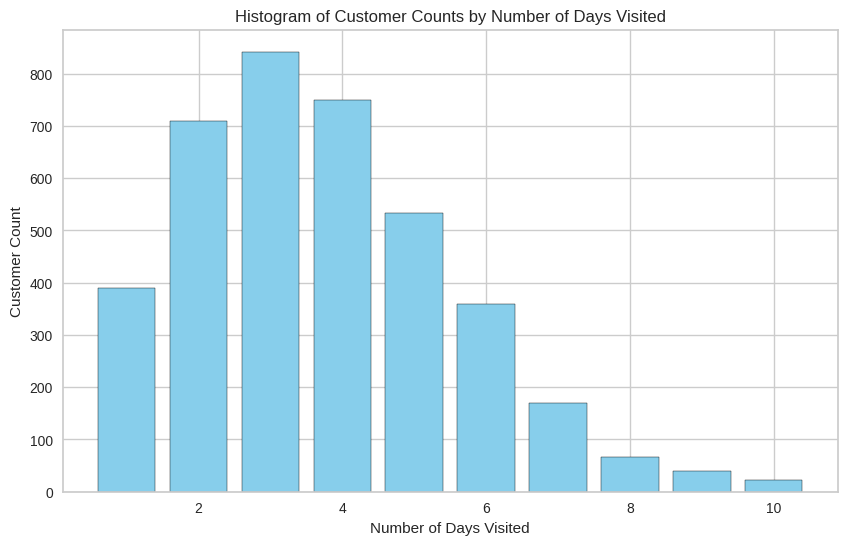

In [24]:

# Compute histogram of customer count for #days visited without binning
hist, bin_edges = np.histogram(df_group, bins=np.arange(min(df_group), max(df_group) + 1, 1))

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=0.8, align='center', color='skyblue', edgecolor='black')
plt.title('Histogram of Customer Counts by Number of Days Visited')
plt.xlabel('Number of Days Visited')
plt.ylabel('Customer Count')
plt.show()


In [25]:
item_purchase_count = df['itemDescription'].value_counts()
item_purchase_count

whole milk               2277
other vegetables         1742
rolls/buns               1587
soda                     1394
yogurt                   1241
                         ... 
frozen chicken              4
rubbing alcohol             4
baby cosmetics              2
preservation products       1
kitchen utensil             1
Name: itemDescription, Length: 167, dtype: int64

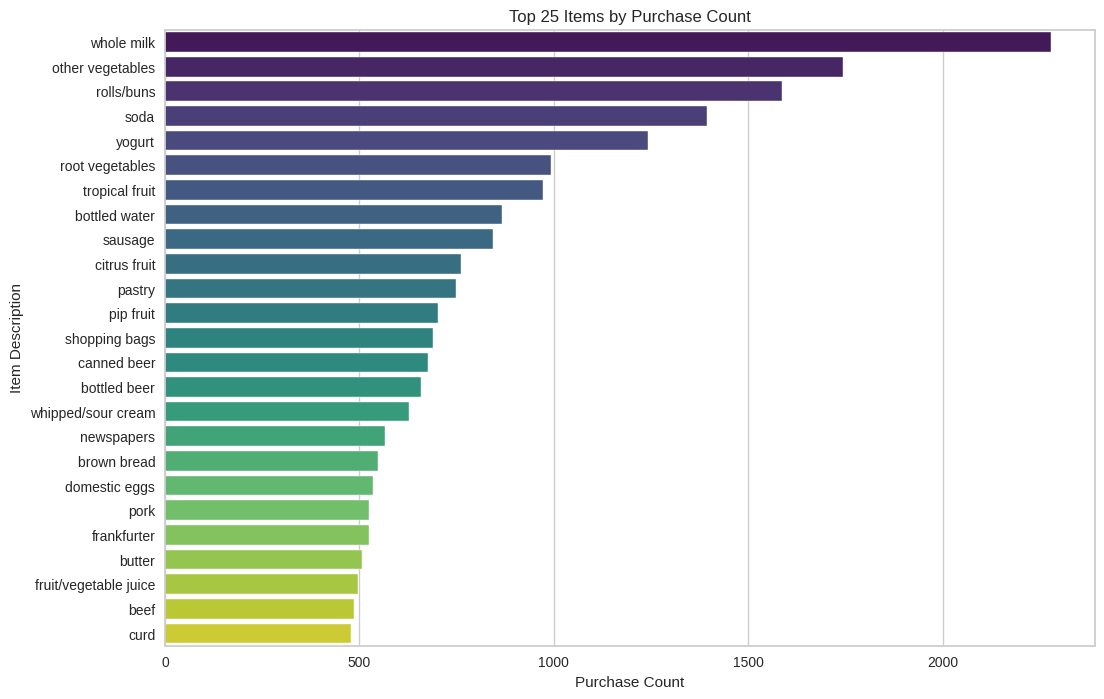

In [26]:
item_purchase_count = df['itemDescription'].value_counts()

# Extract the top 25 items
top_25_items = item_purchase_count.head(25)

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=top_25_items.values, y=top_25_items.index, palette='viridis')
plt.title('Top 25 Items by Purchase Count')
plt.xlabel('Purchase Count')
plt.ylabel('Item Description')
plt.show()

In [27]:

item_purchase_count = df['itemDescription'].value_counts()

# Extract the top 25 items
top_25_items = item_purchase_count.head(25)
top_25_items



whole milk               2277
other vegetables         1742
rolls/buns               1587
soda                     1394
yogurt                   1241
root vegetables           992
tropical fruit            973
bottled water             866
sausage                   843
citrus fruit              760
pastry                    749
pip fruit                 702
shopping bags             688
canned beer               676
bottled beer              659
whipped/sour cream        627
newspapers                566
brown bread               548
domestic eggs             536
pork                      524
frankfurter               524
butter                    507
fruit/vegetable juice     497
beef                      485
curd                      478
Name: itemDescription, dtype: int64

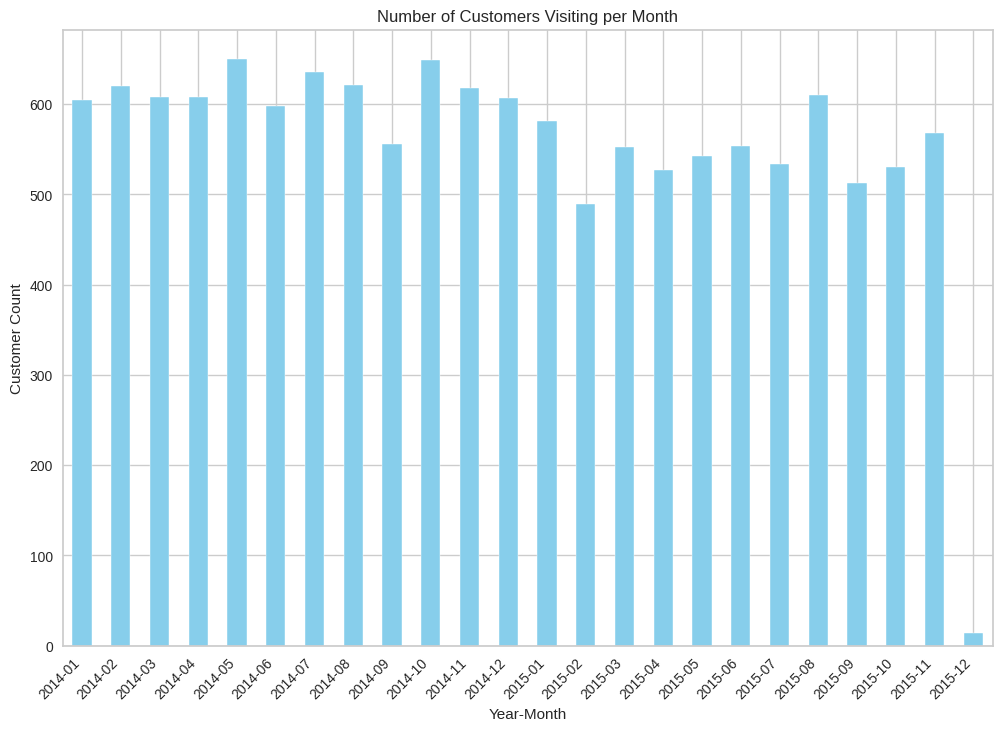

In [28]:

df['Purchase Date Only'] = pd.to_datetime(df['Purchase Date Only'])

# Extract year-month information
df['year_month'] = df['Purchase Date Only'].dt.to_period('M')

# Group by 'Member_number' and count the occurrences
df_monthly_counts = df.groupby(['year_month', 'Member_number']).size().reset_index(name='customer_count')

# Plot the bar plot
plt.figure(figsize=(12, 8))
df_monthly_counts.groupby('year_month')['customer_count'].count().plot(kind='bar', color='skyblue')
plt.title('Number of Customers Visiting per Month')
plt.xlabel('Year-Month')
plt.ylabel('Customer Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


In [29]:
retained_counts = df[[ 'Member_number','Retention']].drop_duplicates().astype(int)

# Count the number of retained and non-retained customers
retained_counts = retained_counts['Retention'].value_counts()
retained_counts


1    3459
0     421
Name: Retention, dtype: int64

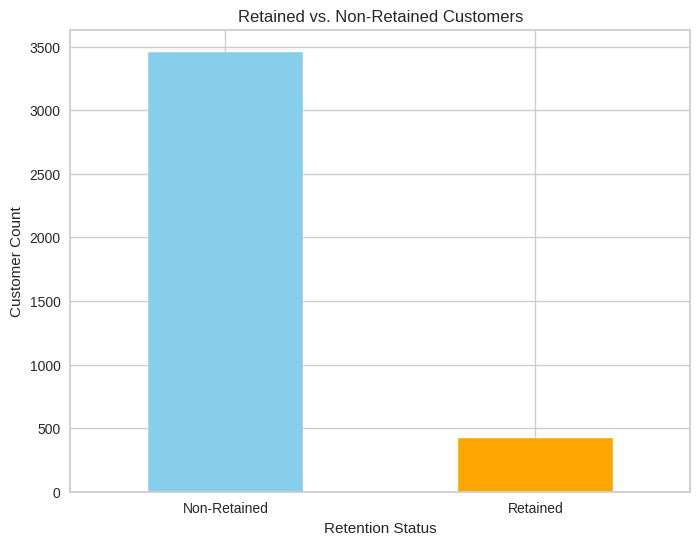

In [30]:

# Plot the bar plot
plt.figure(figsize=(8, 6))
retained_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Retained vs. Non-Retained Customers')
plt.xlabel('Retention Status')
plt.ylabel('Customer Count')
plt.xticks(ticks=[0, 1], labels=['Non-Retained', 'Retained'], rotation=0)
plt.show()

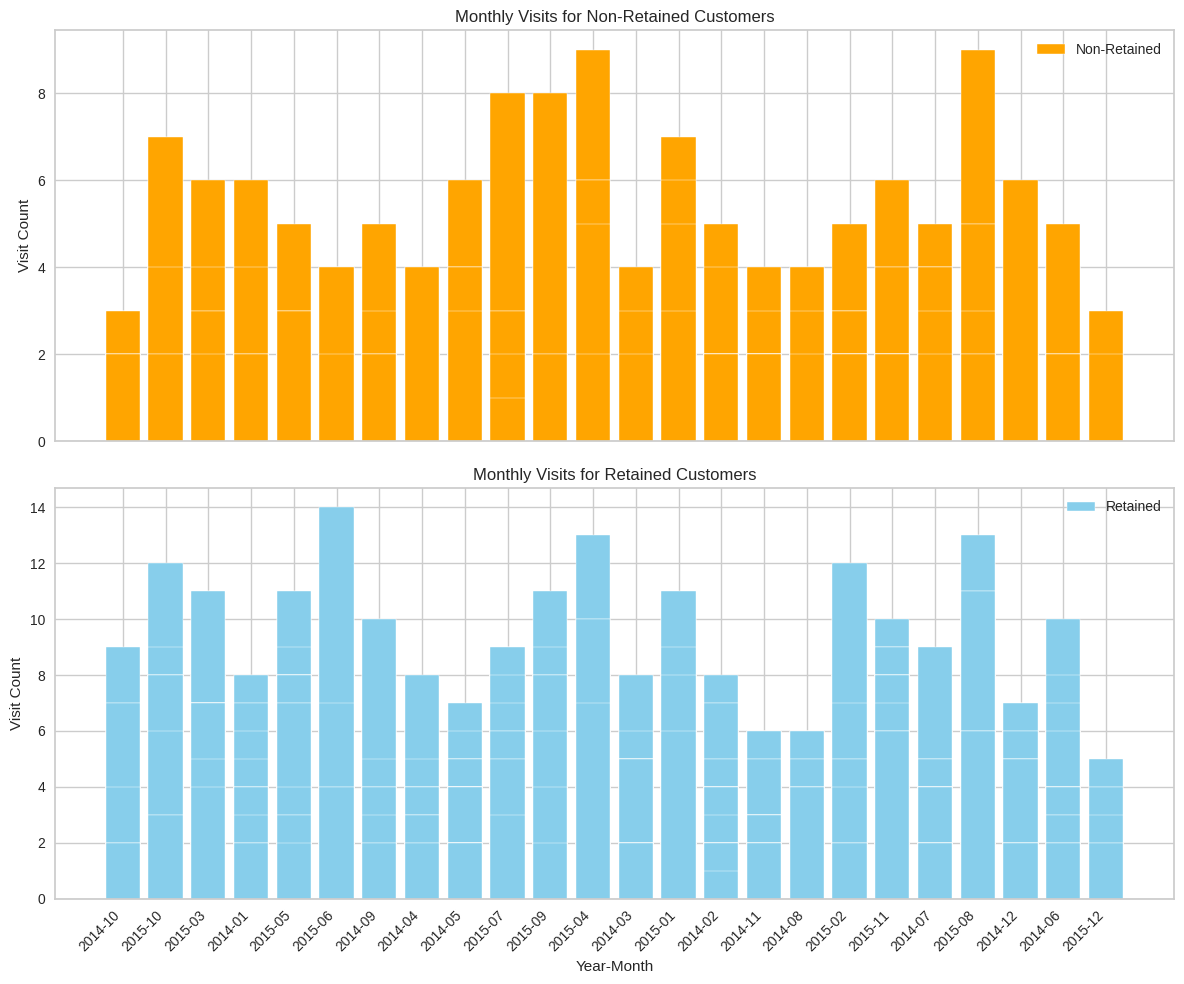

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

# Convert 'Purchase Date Only' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract year-month information
df['year_month'] = df['Date'].dt.to_period('M')

# Group by 'Retention' and 'Member_number', then count the occurrences
df_monthly_counts = df.groupby(['Retention', 'Member_number', 'year_month']).size().reset_index(name='visit_count')

# Create two separate DataFrames for retention status 0 and 1
retention_0 = df_monthly_counts[df_monthly_counts['Retention'] == 0]
retention_1 = df_monthly_counts[df_monthly_counts['Retention'] == 1]

# Create two separate bar plots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Bar plot for retention status 0
axes[0].bar(retention_0['year_month'].astype(str), retention_0['visit_count'], color='orange', label='Non-Retained')
axes[0].set_title('Monthly Visits for Non-Retained Customers')
axes[0].set_ylabel('Visit Count')
axes[0].legend()

# Bar plot for retention status 1
axes[1].bar(retention_1['year_month'].astype(str), retention_1['visit_count'], color='skyblue', label='Retained')
axes[1].set_title('Monthly Visits for Retained Customers')
axes[1].set_xlabel('Year-Month')
axes[1].set_ylabel('Visit Count')
axes[1].legend()

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




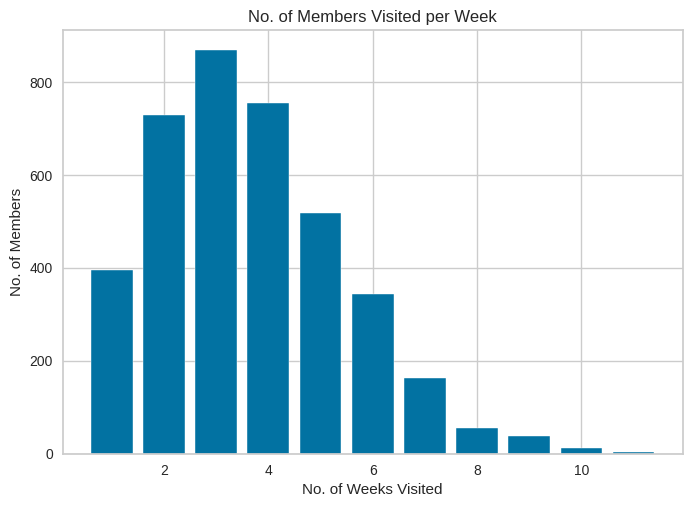

In [32]:
import matplotlib.pyplot as plt

df['NoofWeeksVisited'] = df.groupby('Member_number')['Date'].transform(lambda x: len(x.dt.to_period('W').unique()))
# Get the distinct Member_number values for each NoofWeeksVisited value
result = df.groupby('NoofWeeksVisited')['Member_number'].nunique()

# Plot the barplot
plt.bar(result.index, result.values)
plt.xlabel('No. of Weeks Visited')
plt.ylabel('No. of Members')
plt.title('No. of Members Visited per Week')
plt.show()

In [33]:
# Create a new dataframe to store the results
df_result = pd.DataFrame()

# Get the unique members
members = df['Member_number'].unique()

# Iterate through each member
for member in members:
    # Get the data for the member
    df_member = df[df['Member_number'] == member]

    # Get the start date for the member
    start_date = df_member['Date'].min()

    # Get the number of weeks between start date and last date
    num_weeks = (df['Date'].max() - start_date).days/7

    # Get the number of weeks the member visited the store
    num_weeks_visited = len(df_member['Date'].dt.to_period('W').unique())

    # Calculate the percentage of weeks visited
    percentage_weeks_visited = num_weeks_visited/(num_weeks+1)

    # Add the result to the dataframe
    #Use the pandas.concat() method instead of the frame.append() method:

    #df_result = pd.concat([df_result, {'Member_number': member, 'PercentageWeeksVisited': percentage_weeks_visited}], ignore_index=True)
    df_result = pd.concat([df_result, pd.DataFrame({'Member_number': member, 'PercentageWeeksVisited': percentage_weeks_visited}, index=[0])], ignore_index=True)
    #df_result = df_result.append({'Member_number': member, 'PercentageWeeksVisited': percentage_weeks_visited}, ignore_index=True)

# Merge the result dataframe with the original dataframe
df = df.merge(df_result, on='Member_number', how='left')

In [34]:
df['PercentageWeeksVisited'] = df['PercentageWeeksVisited'].apply(lambda x: 0.15 if x > 0.15 else x)
count_per_percentage = df.groupby(pd.cut(df['PercentageWeeksVisited'], 25))['Member_number'].nunique()
print(count_per_percentage.sort_values(ascending=False))

PercentageWeeksVisited
(0.0379, 0.0435]     468
(0.0491, 0.0548]     403
(0.0323, 0.0379]     366
(0.0267, 0.0323]     348
(0.0435, 0.0491]     341
(0.0211, 0.0267]     303
(0.0548, 0.0604]     281
(0.0604, 0.066]      273
(0.066, 0.0716]      186
(0.0155, 0.0211]     163
(0.0716, 0.0772]     163
(0.00979, 0.0155]    156
(0.0772, 0.0828]      96
(0.0828, 0.0884]      76
(0.0884, 0.094]       61
(0.094, 0.0996]       46
(0.144, 0.15]         41
(0.0996, 0.105]       29
(0.111, 0.116]        19
(0.105, 0.111]        15
(0.122, 0.128]        14
(0.116, 0.122]        12
(0.128, 0.133]         7
(0.133, 0.139]         7
(0.139, 0.144]         6
Name: Member_number, dtype: int64


## ML modelling to detect the feature importance


## Train test split

Done modelling for items and retention

X = items in Data

y = retention

In [35]:
df_items_ml = df_items
df_items_ml.head(1)

itemDescription,member_number,retention,instant food products,uht-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,1000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0


In [36]:
df_items_ml = df_items_ml[df_items_ml['retention'] == 1].sample(frac=0.66).append(df_items_ml[df_items_ml['retention'] == 0])
retained_counts = df_items_ml['retention'].value_counts()
retained_counts

<ipython-input-36-bb8008afb4a2>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_items_ml = df_items_ml[df_items_ml['retention'] == 1].sample(frac=0.66).append(df_items_ml[df_items_ml['retention'] == 0])


1    2283
0     421
Name: retention, dtype: int64

In [37]:
filepath = '/content/drive/retention_data_ml.csv'
df_items_ml.to_csv('/retention_data_ml.csv', index=False)

In [38]:
X = df_items_ml.drop(columns = ['member_number', 'retention'])

y = df_items_ml['retention']

y.head()



2281    1
1990    1
315     1
3382    1
3647    1
Name: retention, dtype: int64

In [39]:
X.head()

itemDescription,instant food products,uht-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
2281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


##### $\rightarrow$ Split the data into training and testing sets. Keep 20% of the data for the test set.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 100)
print(X_train.shape, X_test.shape)

(2163, 167) (541, 167)


##### $\rightarrow$ Check that the training and testing input variables have similar means and standard deviations.

### Scale the numerical predictor variables in the training set to have mean 0 and standard deviation 1.

In [41]:
numerical_columns = X_train.select_dtypes(include='number').columns

In [42]:
scaler = StandardScaler().fit(X_train[numerical_columns])

Perform the scaling transform on the predictors in the training and testing sets.

In [43]:
X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

#### Imputation

In [44]:
imputer = IterativeImputer()

In [45]:
X_train.head()

itemDescription,instant food products,uht-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
2206,-0.110302,-0.269269,-0.068152,-0.091606,-0.021507,-0.037268,-0.161527,-0.05698,-0.336503,-0.279467,...,-0.133895,-0.099395,-0.258122,-0.388453,-0.043043,-0.291126,-0.201064,1.960141,-0.561073,-0.116574
2129,-0.110302,-0.269269,-0.068152,-0.091606,-0.021507,-0.037268,-0.161527,-0.05698,-0.336503,-0.279467,...,-0.133895,-0.099395,-0.258122,-0.388453,-0.043043,-0.291126,-0.201064,0.612038,-0.561073,-0.116574
696,-0.110302,-0.269269,-0.068152,-0.091606,-0.021507,-0.037268,-0.161527,-0.05698,-0.336503,-0.279467,...,-0.133895,-0.099395,-0.258122,-0.388453,-0.043043,-0.291126,-0.201064,1.960141,-0.561073,-0.116574
1432,-0.110302,-0.269269,-0.068152,-0.091606,-0.021507,-0.037268,-0.161527,-0.05698,-0.336503,-0.279467,...,-0.133895,-0.099395,-0.258122,-0.388453,-0.043043,-0.291126,-0.201064,0.612038,1.231542,-0.116574
1456,-0.110302,-0.269269,-0.068152,-0.091606,-0.021507,-0.037268,-0.161527,-0.05698,-0.336503,-0.279467,...,-0.133895,-0.099395,-0.258122,-0.388453,-0.043043,-0.291126,-0.201064,-0.736066,-0.561073,-0.116574


In [46]:

# Assuming 'description' and 'purchase_date' are the non-numeric columns you want to exclude
non_numeric_columns = ['itemdescription', 'purchase date only']

# Identify numeric columns
numeric_columns = X_train.select_dtypes(include=['number']).columns

# Exclude non-numeric columns
numeric_columns_to_impute = [col for col in numeric_columns if col not in non_numeric_columns]


In [47]:
imputer.fit(X_train.loc[:, numeric_columns_to_impute])

IterativeImputer()

In [48]:
X_train.loc[:, numeric_columns_to_impute] = imputer.transform(X_train.loc[:, numeric_columns_to_impute])

##### $\rightarrow$ Create data frames that join the predictor variables and output variable for the training and testing data.

In [49]:
df_train = X_train.join(y_train)

In [50]:
df_test = X_test.join(y_test)

In [51]:
pred_null = np.zeros(len(y_test))

In [52]:
print(classification_report(y_test, pred_null))

              precision    recall  f1-score   support

           0       0.16      1.00      0.28        87
           1       0.00      0.00      0.00       454

    accuracy                           0.16       541
   macro avg       0.08      0.50      0.14       541
weighted avg       0.03      0.16      0.04       541



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Modeling

In [53]:
xgb_model = xgb.XGBClassifier()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3),
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model,
                            param_distributions=params,
                            n_iter=200,
                            cv=5,
                            verbose=1,
                            n_jobs=-1,
                            return_train_score=True)

search.fit(X_train,
           y_train)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c0beafd31f0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c0beafeb700>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c0beafd1600>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c0bf5bbc640>},
                   return_train_score=True, verbose=1)

In [54]:
search.best_params_

{'colsample_bytree': 0.7206126736075489,
 'gamma': 0.06447606422988233,
 'learning_rate': 0.18778775455135474,
 'max_depth': 3,
 'n_estimators': 139,
 'subsample': 0.6860073668860309}

In [55]:
xgb_model = xgb.XGBClassifier()
xgb_model.set_params(**search.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7206126736075489, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.06447606422988233,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18778775455135474,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=139, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Axes: ylabel='itemDescription'>

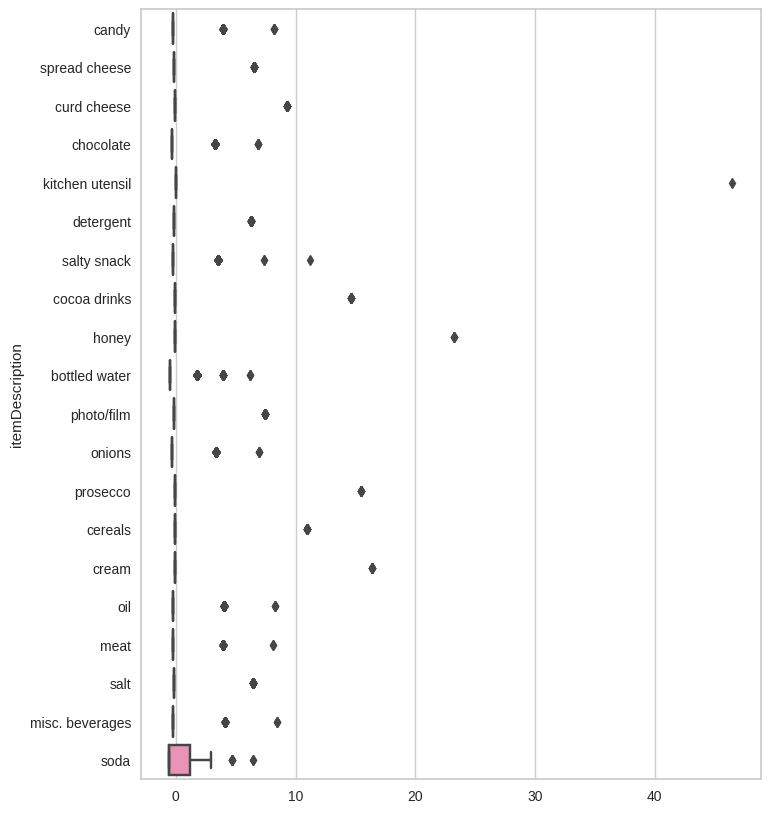

In [56]:

# Randomly select a subset of columns
sample_columns = np.random.choice(X_train.columns, size=20, replace=False)

# Create a boxplot for the sampled columns
plt.figure(figsize=(8, 10))
sns.boxplot(data=X_train[sample_columns], orient='h')


In [57]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7206126736075489, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.06447606422988233,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18778775455135474,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=139, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

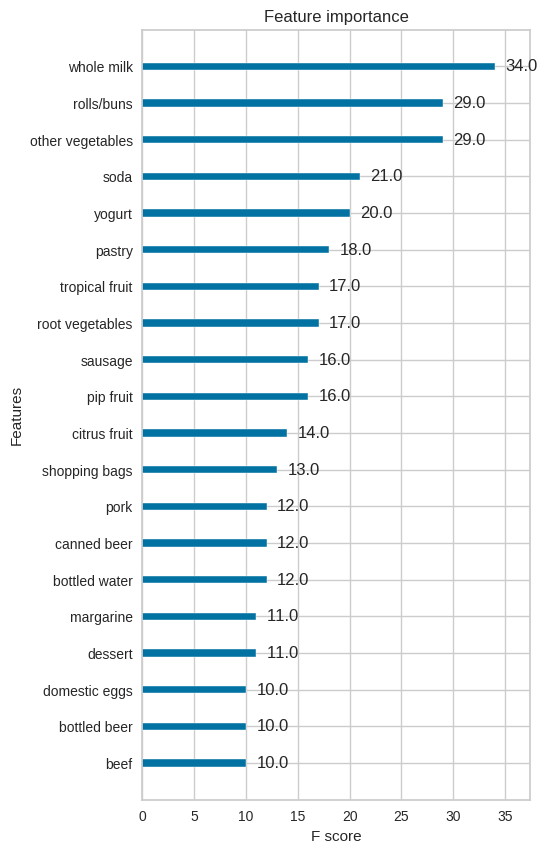

In [58]:
fig, ax = plt.subplots(figsize=(5, 10))
xgb.plot_importance(xgb_model, ax=ax, max_num_features=20)


In [59]:
pred_mgb = xgb_model.predict(X_test)

In [60]:
mat_mgb = confusion_matrix(y_test, pred_mgb)
mat_mgb

array([[ 56,  31],
       [ 17, 437]])

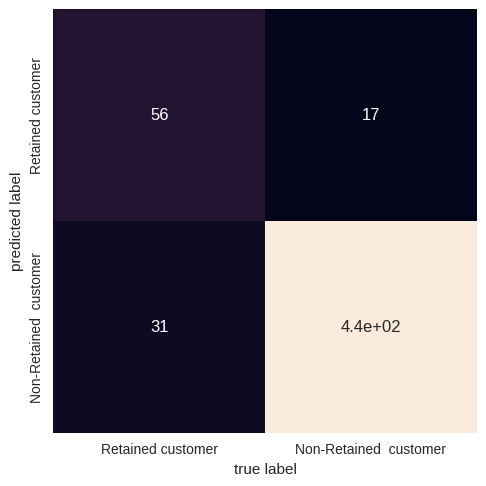

In [61]:
class_names = ['Retained customer', 'Non-Retained  customer']
sns.heatmap(mat_mgb.T, square=True, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [62]:
print(classification_report(y_test, pred_mgb))

              precision    recall  f1-score   support

           0       0.77      0.64      0.70        87
           1       0.93      0.96      0.95       454

    accuracy                           0.91       541
   macro avg       0.85      0.80      0.82       541
weighted avg       0.91      0.91      0.91       541



# Frequent sets analysis using apriori analysis

##### $\rightarrow$  Examine distributions and relationships

##Frequent set for Retention = 1

In [63]:
df_t.head(5)

,Member_number,Date,itemDescription,Purchase Date Only,Quarter_Retention,Retention,Year_Quarter,next_Year_Quarter,Month_Year,Values,year_month,NoofWeeksVisited
17778,1000,2015-05-27,pickled vegetables,2015-05-27,0,1,2015-Q2,2015-Q3,05/2015,1,2015-05,5
8395,1000,2015-03-15,whole milk,2015-03-15,0,1,2015-Q1,2015-Q2,03/2015,1,2015-03,5
24544,1000,2015-03-15,yogurt,2015-03-15,0,1,2015-Q1,2015-Q2,03/2015,1,2015-03,5
13331,1000,2014-06-24,whole milk,2014-06-24,0,1,2014-Q2,2014-Q3,06/2014,1,2014-06,5
18196,1000,2015-07-24,misc. beverages,2015-07-24,0,1,2015-Q3,2015-Q4,07/2015,1,2015-07,5


In [64]:
df_t = df_t.drop(columns=[ 'Year_Quarter', 'Values', 'next_Year_Quarter'])


In [65]:

retention_1_df = df_t[df_t['Retention'] == 1]

print("\nDataFrame for Retention 1:")
retention_1_df


DataFrame for Retention 1:


,Member_number,Date,itemDescription,Purchase Date Only,Quarter_Retention,Retention,Month_Year,year_month,NoofWeeksVisited
17778,1000,2015-05-27,pickled vegetables,2015-05-27,0,1,05/2015,2015-05,5
8395,1000,2015-03-15,whole milk,2015-03-15,0,1,03/2015,2015-03,5
24544,1000,2015-03-15,yogurt,2015-03-15,0,1,03/2015,2015-03,5
13331,1000,2014-06-24,whole milk,2014-06-24,0,1,06/2014,2014-06,5
18196,1000,2015-07-24,misc. beverages,2015-07-24,0,1,07/2015,2015-07,5
...,...,...,...,...,...,...,...,...,...
11728,5000,2014-09-03,fruit/vegetable juice,2014-09-03,0,1,09/2014,2014-09,3
19727,5000,2015-10-02,root vegetables,2015-10-02,0,1,10/2015,2015-10,3
3578,5000,2015-10-02,soda,2015-10-02,0,1,10/2015,2015-10,3
34885,5000,2015-10-02,semi-finished bread,2015-10-02,0,1,10/2015,2015-10,3


Identifing Purchase pattern of retained customers by , member_number, date, itemdescription

In [66]:
df_itemList_ret_1 = retention_1_df.groupby('Member_number').agg(lambda x: ', '.join(x)).reset_index()

# Display the first 15 rows of the result
df_itemList_ret_1.head(15)


<ipython-input-66-5d692c307a8b>:1: FutureWarning: ['Date', 'Purchase Date Only', 'Quarter_Retention', 'Retention', 'year_month', 'NoofWeeksVisited'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_itemList_ret_1 = retention_1_df.groupby('Member_number').agg(lambda x: ', '.join(x)).reset_index()


,Member_number,itemDescription,Month_Year
0,1000,"pickled vegetables, whole milk, yogurt, whole ...","05/2015, 03/2015, 03/2015, 06/2014, 07/2015, 0..."
1,1001,"frankfurter, white bread, rolls/buns, frankfur...","02/2015, 04/2015, 07/2014, 01/2015, 07/2014, 0..."
2,1002,"specialty chocolate, butter, whole milk, tropi...","08/2015, 04/2014, 04/2014, 04/2015, 04/2015, 0..."
3,1003,"sausage, dental care, rolls/buns, root vegetab...","10/2015, 01/2014, 02/2014, 10/2014, 10/2015, 1..."
4,1004,"pip fruit, chocolate, whole milk, red/blush wi...","04/2014, 10/2014, 10/2014, 10/2014, 01/2014, 0..."
5,1005,"rolls/buns, margarine, whipped/sour cream","09/2014, 01/2014, 01/2014"
6,1006,"bottled water, shopping bags, rolls/buns, fran...","05/2014, 11/2014, 06/2015, 06/2015, 06/2015, 1..."
7,1008,"dessert, white wine, liquor (appetizer), yogur...","03/2015, 07/2015, 03/2015, 07/2015, 03/2015, 0..."
8,1009,"herbs, pastry, tropical fruit, yogurt, yogurt,...","05/2015, 09/2015, 05/2015, 05/2015, 05/2015, 0..."
9,1010,"specialty bar, bottled water, kitchen towels, ...","08/2014, 08/2014, 10/2014, 05/2014, 07/2015, 0..."


combined all items into list

In [67]:
transactions = [a[1]['itemDescription'].tolist() for a in list(df_itemList_ret_1.groupby(['Member_number']))] ## Combing all the items in list format for each customer
transactions

<ipython-input-67-0f56dc761ea1>:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  transactions = [a[1]['itemDescription'].tolist() for a in list(df_itemList_ret_1.groupby(['Member_number']))] ## Combing all the items in list format for each customer


[['pickled vegetables, whole milk, yogurt, whole milk, misc. beverages, soda, sausage, hygiene articles, pastry, sausage, salty snack, semi-finished bread, canned beer'],
 ['frankfurter, white bread, rolls/buns, frankfurter, whole milk, curd, soda, beef, soda, whipped/sour cream, whole milk, sausage'],
 ['specialty chocolate, butter, whole milk, tropical fruit, sugar, frozen vegetables, other vegetables, butter milk'],
 ['sausage, dental care, rolls/buns, root vegetables, rolls/buns, detergent, frozen meals'],
 ['pip fruit, chocolate, whole milk, red/blush wine, cling film/bags, frozen fish, rolls/buns, root vegetables, chocolate, rolls/buns, canned beer, hygiene articles, whole milk, whole milk, shopping bags, other vegetables, other vegetables, dish cleaner, tropical fruit, pastry, packaged fruit/vegetables'],
 ['rolls/buns, margarine, whipped/sour cream'],
 ['bottled water, shopping bags, rolls/buns, frankfurter, flour, skin care, softener, rice, rolls/buns, chicken, chocolate, whol

In [68]:
baskets = retention_1_df.groupby(['Member_number', 'itemDescription'])['itemDescription'].count().unstack().fillna(0).reset_index()
baskets.head()

itemDescription,Member_number,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
1,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
2,1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


In [69]:
def one_hot_encoder(k):
    if k <= 0:
        return 0
    if k >= 1:
        return 1

In [70]:
baskets_final = baskets.iloc[:, 1:baskets.shape[1]].applymap(one_hot_encoder)
baskets_final.head()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [71]:
from mlxtend.frequent_patterns import apriori
# Finding the most frequent items sold together
frequent_itemsets = apriori(baskets_final, min_support=0.005, use_colnames=True, max_len=3).sort_values(by='support', ascending=False)
frequent_itemsets.head(25)


/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
138,0.478751,(whole milk)
85,0.391154,(other vegetables)
101,0.366580,(rolls/buns)
115,0.325528,(soda)
139,0.296618,(yogurt)
131,0.243134,(tropical fruit)
102,0.241688,(root vegetables)
9,0.222319,(bottled water)
107,0.212489,(sausage)
1936,0.200925,"(other vegetables, whole milk)"


In [72]:
from mlxtend.frequent_patterns import association_rules
# Creating association rules for indicating astecedent and consequent items
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1).sort_values('lift', ascending=False)
rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
rules.head(25)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,support,confidence,lift
27055,"(sausage, fruit/vegetable juice)",(frozen meals),0.005782,0.186916,2.774859
27058,(frozen meals),"(sausage, fruit/vegetable juice)",0.005782,0.085837,2.774859
26482,"(domestic eggs, yogurt)",(chewing gum),0.005782,0.125786,2.719340
26483,(chewing gum),"(domestic eggs, yogurt)",0.005782,0.125000,2.719340
27834,"(rolls/buns, butter)",(soft cheese),0.005493,0.106145,2.699680
27835,(soft cheese),"(rolls/buns, butter)",0.005493,0.139706,2.699680
28093,(meat),"(bottled water, domestic eggs)",0.005493,0.085586,2.643219
28092,"(bottled water, domestic eggs)",(meat),0.005493,0.169643,2.643219
21064,"(other vegetables, fruit/vegetable juice)",(cat food),0.006649,0.118557,2.579167
21069,(cat food),"(other vegetables, fruit/vegetable juice)",0.006649,0.144654,2.579167


## Frequent Sets analysis for Retetion=0

In [73]:
retention_0_df = df_t[df_t['Retention'] == 0]

print("\nDataFrame for Retention 0:")
retention_0_df


DataFrame for Retention 0:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Member_number,Date,itemDescription,Purchase Date Only,Quarter_Retention,Retention,Month_Year,year_month,NoofWeeksVisited
11210,1019,2014-10-12,hamburger meat,2014-10-12,0,0,10/2014,2014-10,1
27359,1019,2014-10-12,red/blush wine,2014-10-12,0,0,10/2014,2014-10,1
23344,1024,2015-10-08,other vegetables,2015-10-08,0,0,10/2015,2015-10,1
16267,1024,2015-10-08,tropical fruit,2015-10-08,0,0,10/2015,2015-10,1
118,1024,2015-10-08,fish,2015-10-08,0,0,10/2015,2015-10,1
...,...,...,...,...,...,...,...,...,...
37788,4995,2014-02-06,domestic eggs,2014-02-06,0,0,02/2014,2014-02,2
28695,4995,2014-03-16,dish cleaner,2014-03-16,0,0,03/2014,2014-03,2
12546,4995,2014-03-16,rice,2014-03-16,0,0,03/2014,2014-03,2
19899,4998,2015-10-14,curd,2015-10-14,0,0,10/2015,2015-10,1


In [74]:
df_itemList_ret_0 = retention_0_df.groupby(['Member_number', 'Date'])['itemDescription'].agg(lambda x: ', '.join(x)).reset_index()

# Display the first 15 rows of the result
df_itemList_ret_0.head(15)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Member_number,Date,itemDescription
0,1019,2014-10-12,"hamburger meat, red/blush wine"
1,1024,2015-10-08,"other vegetables, tropical fruit, fish, root v..."
2,1029,2015-03-14,"ham, dessert"
3,1036,2014-01-20,"vinegar, fruit/vegetable juice"
4,1039,2015-05-31,"salty snack, rolls/buns"
5,1046,2015-06-18,"pastry, whole milk"
6,1046,2015-06-24,"pork, bottled water"
7,1071,2014-09-26,"fruit/vegetable juice, yogurt, roll products"
8,1084,2014-04-18,"other vegetables, pip fruit"
9,1089,2014-05-12,"sauces, yogurt"


In [75]:
transactions = [a[1]['itemDescription'].tolist() for a in list(df_itemList_ret_0.groupby(['Member_number', 'Date']))] ## Combing all the items in list format for each customer
transactions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['hamburger meat, red/blush wine'],
 ['other vegetables, tropical fruit, fish, root vegetables'],
 ['ham, dessert'],
 ['vinegar, fruit/vegetable juice'],
 ['salty snack, rolls/buns'],
 ['pastry, whole milk'],
 ['pork, bottled water'],
 ['fruit/vegetable juice, yogurt, roll products '],
 ['other vegetables, pip fruit'],
 ['sauces, yogurt'],
 ['domestic eggs, dessert'],
 ['fruit/vegetable juice, pip fruit'],
 ['dish cleaner, jam, ice cream, newspapers'],
 ['whole milk, meat, whipped/sour cream'],
 ['whole milk, grapes'],
 ['shopping bags, coffee'],
 ['berries, other vegetables'],
 ['other vegetables, sliced cheese'],
 ['root vegetables, canned vegetables, whole milk'],
 ['root vegetables, brown bread'],
 ['tropical fruit, bottled water'],
 ['brown bread, canned beer, rolls/buns, dessert'],
 ['candles, whole milk'],
 ['coffee, misc. beverages'],
 ['brown bread, canned beer'],
 ['instant coffee, red/blush wine'],
 ['bottled water, sugar'],
 ['coffee, canned beer'],
 ['condensed milk, onio

In [76]:
baskets_0 = retention_0_df.groupby(['Member_number', 'itemDescription'])['itemDescription'].count().unstack().fillna(0).reset_index()
baskets_0.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


itemDescription,Member_number,Instant food products,UHT-milk,abrasive cleaner,baby cosmetics,baking powder,beef,berries,beverages,bottled beer,...,tea,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,white bread,white wine,whole milk,yogurt
0,1019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
baskets_final_0 = baskets_0.iloc[:, 1:baskets_0.shape[1]].applymap(one_hot_encoder)
baskets_final_0.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


itemDescription,Instant food products,UHT-milk,abrasive cleaner,baby cosmetics,baking powder,beef,berries,beverages,bottled beer,bottled water,...,tea,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,white bread,white wine,whole milk,yogurt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
frequent_itemsets_0 = apriori(baskets_final_0, min_support=0.005, use_colnames=True, max_len=3).sort_values(by='support', ascending=False)
frequent_itemsets_0.head(25)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
82,0.166271,(whole milk)
50,0.154394,(other vegetables)
62,0.133017,(rolls/buns)
71,0.130641,(soda)
83,0.102138,(yogurt)
77,0.097387,(tropical fruit)
5,0.071259,(bottled water)
55,0.066508,(pip fruit)
19,0.064133,(citrus fruit)
63,0.061758,(root vegetables)


In [79]:
rules = association_rules(frequent_itemsets_0, metric="lift", min_threshold=1).sort_values('lift', ascending=False)
rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
rules.head(25)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,support,confidence,lift
125,(bottled beer),(domestic eggs),0.007126,0.214286,4.748120
124,(domestic eggs),(bottled beer),0.007126,0.157895,4.748120
60,(tropical fruit),(UHT-milk),0.009501,0.097561,4.563686
61,(UHT-milk),(tropical fruit),0.009501,0.444444,4.563686
106,(sugar),(yogurt),0.007126,0.428571,4.196013
107,(yogurt),(sugar),0.007126,0.069767,4.196013
187,(butter),(chicken),0.007126,0.166667,4.127451
186,(chicken),(butter),0.007126,0.176471,4.127451
147,(brown bread),(napkins),0.007126,0.136364,4.100649
146,(napkins),(brown bread),0.007126,0.214286,4.100649


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-87-73a5a6392a49>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_t.corr().drop(columns=column_to_drop, index=column_to_drop, errors='ignore')


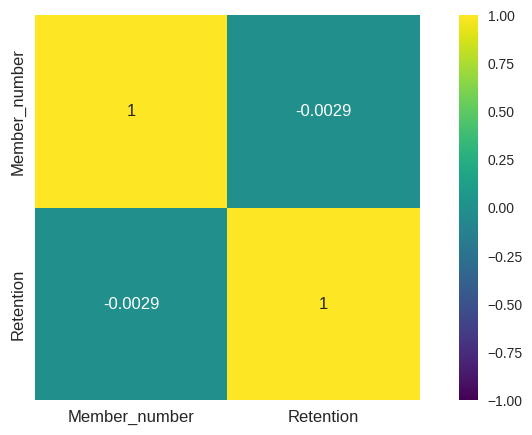

In [87]:
column_to_drop = ['Quarter_Retention','NoofWeeksVisited']
corr_matrix = df_t.corr().drop(columns=column_to_drop, index=column_to_drop, errors='ignore')

plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap='viridis')
plt.tick_params(labelsize=12)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
